In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchinfo
import torchtext.transforms as T
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.schemas import NlpContext
from torchlake.common.utils.text import build_vocab
from torchlake.text_classification.constants.misc import CHARACTERS
from torchlake.text_classification.models import CharCnn

# setting


In [2]:
data_path = Path("../../data/covid-tweet")
artifacts_path = Path("../../artifacts/charcnn")

In [3]:
batch_size = 128
CONTEXT = NlpContext(max_seq_len=27*34+96)

# data

In [4]:
train_data = pd.read_csv(
    data_path.joinpath("Corona_NLP_train.csv").as_posix(),
    encoding='latin-1',
    usecols=['OriginalTweet', 'Sentiment'],
)

In [5]:
test_data = pd.read_csv(
    data_path.joinpath("Corona_NLP_test.csv").as_posix(),
    encoding='latin-1',
    usecols=['OriginalTweet', 'Sentiment'],
)

In [6]:
train_data['Sentiment'].value_counts()

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [7]:
vocab = build_vocab([*CHARACTERS], context=CONTEXT)

In [8]:
train_data['OriginalTweet'] = train_data['OriginalTweet'].str.lower()
test_data['OriginalTweet'] = test_data['OriginalTweet'].str.lower()

In [9]:
label_encoder = LabelEncoder()
train_data['Sentiment'] = label_encoder.fit_transform(train_data['Sentiment'])

In [10]:
test_data['Sentiment'] = label_encoder.transform(test_data['Sentiment'])

In [11]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [12]:
def collate_fn(batch: np.ndarray):
    text_placeholder, label_placeholder = [], []

    for text, label in batch:
        text = [*text]
        text = text_transform(text)
        text_placeholder.append(text)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.Tensor(label_placeholder)

In [13]:
train_iter = DataLoader(
    train_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

test_iter = DataLoader(
    test_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
)

# model


In [15]:
VOCAB_SIZE = len(vocab)
NUM_CLASS = train_data['Sentiment'].nunique()

In [16]:
DEVICE = torch.device(CONTEXT.device)

In [17]:
model = CharCnn(VOCAB_SIZE, NUM_CLASS, CONTEXT).to(DEVICE)

In [18]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
CharCnn                                  --
├─CharQuantization: 1-1                  --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-1                       129,280
│    └─ReLU: 2-2                         --
│    └─MaxPool1d: 2-3                    --
│    └─Conv1d: 2-4                       459,008
│    └─ReLU: 2-5                         --
│    └─MaxPool1d: 2-6                    --
│    └─Conv1d: 2-7                       196,864
│    └─ReLU: 2-8                         --
│    └─Conv1d: 2-9                       196,864
│    └─ReLU: 2-10                        --
│    └─Conv1d: 2-11                      196,864
│    └─ReLU: 2-12                        --
│    └─Conv1d: 2-13                      196,864
│    └─ReLU: 2-14                        --
│    └─MaxPool1d: 2-15                   --
├─Sequential: 1-3                        --
│    └─Linear: 2-16                      8,913,920
│    └─Dropout: 2-17              

# train


In [19]:
EPOCHES = 30

In [20]:
trainer = ClassificationTrainer(EPOCHES, DEVICE)

In [21]:
criterion = trainer.get_criterion(NUM_CLASS, ignore_index=CONTEXT.padding_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [22]:
training_loss = trainer.run(train_iter, model, optimizer, criterion)

100%|██████████| 321/321 [00:11<00:00, 26.89it/s]


epoch 1 : 0.010582326505205528


100%|██████████| 321/321 [00:11<00:00, 28.86it/s]


epoch 2 : 0.010463196163376173


100%|██████████| 321/321 [00:10<00:00, 29.74it/s]


epoch 3 : 0.010426812088610227


100%|██████████| 321/321 [00:10<00:00, 30.32it/s]


epoch 4 : 0.010078869281319257


100%|██████████| 321/321 [00:10<00:00, 30.19it/s]


epoch 5 : 0.009520936531023445


100%|██████████| 321/321 [00:10<00:00, 30.08it/s]


epoch 6 : 0.009050450830305477


100%|██████████| 321/321 [00:10<00:00, 31.25it/s]


epoch 7 : 0.0086939340207807


100%|██████████| 321/321 [00:10<00:00, 31.58it/s]


epoch 8 : 0.008255252647982486


100%|██████████| 321/321 [00:11<00:00, 28.43it/s]


epoch 9 : 0.0077967739771366866


100%|██████████| 321/321 [00:11<00:00, 28.77it/s]


epoch 10 : 0.007335042550498359


100%|██████████| 321/321 [00:11<00:00, 28.09it/s]


epoch 11 : 0.006989976086558026


100%|██████████| 321/321 [00:11<00:00, 29.03it/s]


epoch 12 : 0.006572263762122745


100%|██████████| 321/321 [00:10<00:00, 29.97it/s]


epoch 13 : 0.006262495143286815


100%|██████████| 321/321 [00:10<00:00, 29.23it/s]


epoch 14 : 0.00575156470273282


100%|██████████| 321/321 [00:10<00:00, 30.70it/s]


epoch 15 : 0.005316401833981694


100%|██████████| 321/321 [00:10<00:00, 29.47it/s]


epoch 16 : 0.005012303404364956


100%|██████████| 321/321 [00:11<00:00, 28.66it/s]


epoch 17 : 0.004598189087300286


100%|██████████| 321/321 [00:13<00:00, 23.32it/s]


epoch 18 : 0.004072405858475982


100%|██████████| 321/321 [00:12<00:00, 25.37it/s]


epoch 19 : 0.0034767561722720895


100%|██████████| 321/321 [00:10<00:00, 29.70it/s]


epoch 20 : 0.0028837850020699365


100%|██████████| 321/321 [00:11<00:00, 28.23it/s]


epoch 21 : 0.002390187798717822


100%|██████████| 321/321 [00:11<00:00, 27.21it/s]


epoch 22 : 0.002347412589151192


100%|██████████| 321/321 [00:11<00:00, 28.96it/s]


epoch 23 : 0.0019486924443710188


100%|██████████| 321/321 [00:10<00:00, 29.81it/s]


epoch 24 : 0.001336179764972524


100%|██████████| 321/321 [00:11<00:00, 27.86it/s]


epoch 25 : 0.001272583861597393


100%|██████████| 321/321 [00:11<00:00, 28.83it/s]


epoch 26 : 0.001060351208062709


100%|██████████| 321/321 [00:10<00:00, 29.37it/s]


epoch 27 : 0.001209246717885534


100%|██████████| 321/321 [00:10<00:00, 29.80it/s]


epoch 28 : 0.0005978804343794197


100%|██████████| 321/321 [00:11<00:00, 28.38it/s]


epoch 29 : 0.0009876026055382818


100%|██████████| 321/321 [00:10<00:00, 29.63it/s]

epoch 30 : 0.0006144882111207762


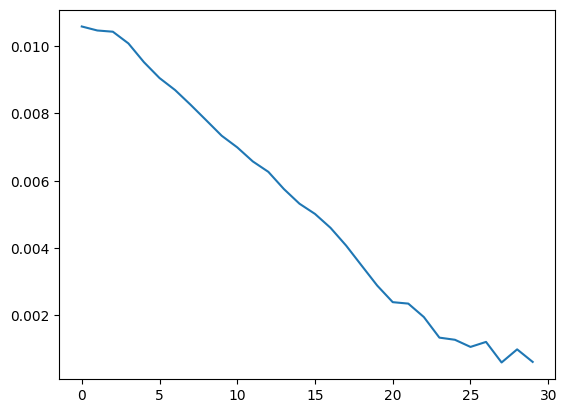

In [23]:
plt.plot(training_loss)

# inference


In [24]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE)

In [25]:
train_confusion_matrix = evaluator.run(train_iter, model)

100%|██████████| 321/321 [00:10<00:00, 30.44it/s]

0.8026674454828661


In [26]:
test_confusion_matrix = evaluator.run(test_iter, model)

100%|██████████| 30/30 [00:01<00:00, 25.12it/s]

0.44549763033175355


In [27]:
per_class_accs = evaluator.get_per_class_accuracy(test_confusion_matrix)
evaluator.show_per_class_accuracy(label_encoder.classes_, per_class_accs.round(4))

Extremely Negative: 0.4324
Extremely Positive: 0.5509
Negative  : 0.5591
Neutral   : 0.0
Positive  : 0.5533


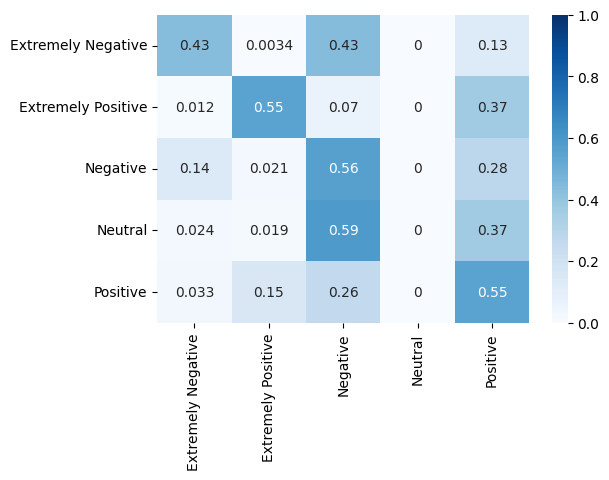

In [32]:
evaluator.plot_confusion_matrix(test_confusion_matrix, label_encoder.classes_, cmap='Blues', figsize=(6, 4))

In [29]:
model_path = artifacts_path.joinpath("charcnn.pth")

In [30]:
torch.save(model.state_dict(), model_path)

In [31]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>